# View: abundance_order_habitat
Project:Dataset in BQ: **mpg-data-warehouse:bird_point_count_summaries**

This view will allow us to analyze basic trends in bird abundance among habitats at MPG. Initially, such summaries are necessary for the MPG Matrix. To produce the view, the bird data must first be summarized to obtain abundances by taxonomic order at each grid point. There will be several steps to consider how to account for the number of technician visits per year and the number of points visited per year. Then, the summarized bird data will be joined to a habitat classification from grid point metadata.

* Documentation: [Readme bird point count monitoring](https://docs.google.com/document/d/1PRryJzGOUtfr-fKXzb3tbr48xiaTuAMVk18XFXlvxcM/edit?usp=sharing)

## Updates will be necessary
* **2020-05-22**. Right now, this file must pull data from a csv in GD, rather than a view in BQ as intended. This is due to an [OAuth issue](https://colab.research.google.com/drive/1NkqB9RXRpMl2m4fwTy3H5rz1SDwCA_DE#scrollTo=EIn9rVWbwOMo&line=1&uniqifier=1) that we are looking into. Make sure that we evenually circle back and confirm that this notebook is pulling data from BQ, whether we have to flatten the source files, or if we learn how to manage GD OAuth.
* **2020-05-22**. Right now, abundance summaries for the MPG Matrix are processed in this notebook. Once we are able to solve the issue from (1), move the abundance summaires to a new notebook located in the Matrix directory. 

# Tools

In [0]:
library(tidyverse)

In [0]:
install.packages("bigrquery")
library(bigrquery)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bit’, ‘bit64’, ‘gargle’, ‘rapidjsonr’




# Source

## BigQuery

### Database Connection

In [0]:
# BigQuery API Key
bq_auth(path = "/content/mpg-data-warehouse-api_key-master.json")

In [0]:
Sys.setenv(BIGQUERY_TEST_PROJECT = "mpg-data-warehouse")

In [0]:
billing <- bq_test_project()

In [0]:
con_bird_point_counts <- dbConnect(
  bigrquery::bigquery(),
  project = "mpg-data-warehouse",
  dataset = "bird_point_counts",
  billing = billing
)

In [0]:
con_location_position_classification <- dbConnect(
    bigrquery::bigquery(),
  project = "mpg-data-warehouse",
  dataset = "grid_point_summaries",
  billing = billing
)

In [0]:
dbListTables(con_bird_point_counts)

[1] "bird_surveyInfo_records_function" "bird_survey_noise"               
[3] "bird_survey_sky"                  "bird_survey_wind"

In [0]:
dbListTables(con_location_position_classification)

[1] "location"                         "location_position_classification"
[3] "point_location_position"

### Query Database

#### bird_point_counts

In [0]:
bird_sql <- "SELECT *
             FROM `mpg-data-warehouse.bird_point_counts.bird_surveyInfo_records_function`"

In [0]:
# result bird table
bq_bird <- bq_project_query(billing, bird_sql)

In [0]:
tb_bird = bq_table_download(bq_bird)

In [0]:
class(tb_bird)

[1] "tbl_df"     "tbl"        "data.frame"

In [0]:
df_bird <- as.data.frame(tb_bird)

In [0]:
str(df_bird)

'data.frame':	117810 obs. of  31 variables:
 $ survey_ID                         : int  4915 4915 4915 4915 4915 4915 4915 4915 4915 4915 ...
 $ survey_year                       : int  2013 2013 2013 2013 2013 2013 2013 2013 2013 2013 ...
 $ survey_date                       : Date, format: "2013-06-17" "2013-06-17" ...
 $ survey_visit_calc                 : int  2 2 2 2 2 2 2 2 2 2 ...
 $ survey_time_start_MDT             : 'hms' num  08:27:00 08:27:00 08:27:00 08:27:00 ...
  ..- attr(*, "units")= chr "secs"
 $ survey_time_end_MDT               : 'hms' num  08:37:00 08:37:00 08:37:00 08:37:00 ...
  ..- attr(*, "units")= chr "secs"
 $ survey_grid_point                 : int  179 179 179 179 179 179 179 179 179 179 ...
 $ survey_observer                   : chr  "Katharine Stone" "Katharine Stone" "Katharine Stone" "Katharine Stone" ...
 $ survey_wind_code                  : int  3 3 3 3 3 3 3 3 3 3 ...
 $ survey_sky_code                   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ survey_noise

#### location_position_classification

In [0]:
location_sql <- "SELECT *
                 FROM `mpg-data-warehouse.grid_point_summaries.location_position_classification`"

Leave the following error for now.  To move forward in the present output csv from table `mpg-data-warehouse.grid_point_summaries.location_position_classification`

In [0]:
bq_location <- bq_project_query(billing, location_sql)

ERROR: ignored

## CSV

### location_position_classification

In [0]:
# MPG Ranch Datasets > Bird point count monitoring > Data - Processed > location_position_classification.csv
src_location = "https://drive.google.com/uc?id=1z1nFdsk0vZXhw78rB3ijrFcLX2mF4VBQ"
df_location <- read_csv(src_location)

Parsed with column specification:
cols(
  grid_point = col_double(),
  lat = col_double(),
  long = col_double(),
  aspect_mean_deg = col_double(),
  elevation_mean_m = col_double(),
  slope_mean_deg = col_double(),
  cover_type_2016_gridVeg = col_character(),
  biomass_habitat_type = col_character(),
  type1_biome = col_character(),
  type2_vegetation_community = col_character(),
  type3_vegetation_indicators = col_character(),
  type4_indicators_history = col_character()
)



# Structure

## bird_point_counts

* There are 218 missing records in `function_taxa_order` that result from the bird records summary below. They result from the various "unknown bird" designations possible in the species list, and are acceptable to disregard. 
* There are 21 missing records in `records_abundance`, but these are eliminated using the sum() function in the first summary. 

In [0]:
bird_abundance <- df_bird %>%
  filter(records_detect_distance_min_meters <= 100,
         records_interval %in% c(1, 2)) %>%
  group_by(survey_year, survey_visit_calc, survey_grid_point, function_taxa_order) %>%
  summarize(bird_abundance = sum(records_abundance)) %>%
  group_by(survey_year, survey_grid_point, function_taxa_order) %>%
  summarize(bird_abundance_avg = mean(bird_abundance)) %>% 
  ungroup() %>% 
  drop_na() %>% 
  glimpse()

Rows: 7,064
Columns: 4
$ survey_year         <int> 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2…
$ survey_grid_point   <int> 1, 1, 1, 2, 2, 3, 3, 4, 4, 6, 7, 7, 7, 8, 8, 9, 9…
$ function_taxa_order <chr> "Accipitriformes", "Galliformes", "Passeriformes"…
$ bird_abundance_avg  <dbl> 1.0, 1.0, 17.0, 1.0, 7.0, 1.0, 8.0, 1.0, 5.5, 7.5…


In [0]:
bird_abundance %>% filter(survey_grid_point == 300)

survey_year,survey_grid_point,function_taxa_order,bird_abundance_avg
<int>,<int>,<chr>,<dbl>
2011,300,Galliformes,1.0
2011,300,Passeriformes,11.0
2012,300,Passeriformes,7.0
2013,300,Passeriformes,3.5
2014,300,Passeriformes,4.5
2015,300,Falconiformes,1.0
2015,300,Passeriformes,9.0
2015,300,Piciformes,1.0
2016,300,Columbiformes,2.0


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



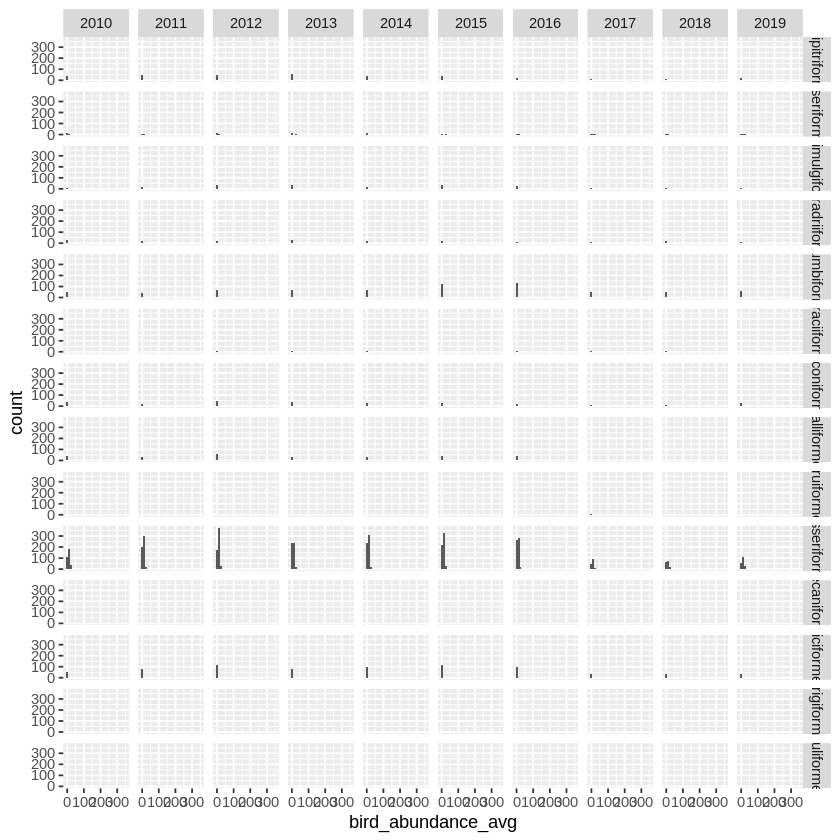

In [0]:
bird_abundance %>% 
ggplot(aes(x = bird_abundance_avg)) +
geom_histogram() +
facet_grid(cols = vars(survey_year), rows = vars(function_taxa_order))

# Join tables
Join **grid point metadata** and **bird records** with selected columns to produce the desired view.

* 2020-05-22 BL initial diagnostics on this look good




In [0]:
names(bird_abundance)

[1] "survey_year"         "survey_grid_point"   "function_taxa_order"
[4] "bird_abundance_avg"

In [0]:
names(df_location)

[1] "grid_point"                  "lat"                        
 [3] "long"                        "aspect_mean_deg"            
 [5] "elevation_mean_m"            "slope_mean_deg"             
 [7] "cover_type_2016_gridVeg"     "biomass_habitat_type"       
 [9] "type1_biome"                 "type2_vegetation_community" 
[11] "type3_vegetation_indicators" "type4_indicators_history"

In [0]:
bird_abundance %>% 
  left_join(df_location %>% select(grid_point, starts_with("cover"), starts_with("biomass"), starts_with("type")), 
            by = c("survey_grid_point" = "grid_point")) %>%
  glimpse()

Rows: 7,286
Columns: 10
$ survey_year                 <int> 2010, 2010, 2010, 2010, 2010, 2010, 2010,…
$ survey_grid_point           <dbl> 1, 1, 1, 2, 2, 3, 3, 4, 4, 6, 7, 7, 7, 8,…
$ function_taxa_order         <chr> "Accipitriformes", "Galliformes", "Passer…
$ bird_abundance_avg          <dbl> 1.0, 1.0, 17.0, 1.0, 7.0, 1.0, 8.0, 1.0, …
$ cover_type_2016_gridVeg     <chr> "woodland/forest", "woodland/forest", "wo…
$ biomass_habitat_type        <chr> NA, NA, NA, "Range", "Range", "Range", "R…
$ type1_biome                 <chr> "forest", "forest", "forest", "rangeland"…
$ type2_vegetation_community  <chr> "upland", "upland", "upland", "grassland"…
$ type3_vegetation_indicators <chr> "mixed canopy conifer", "mixed canopy con…
$ type4_indicators_history    <chr> "mixed canopy conifer", "mixed canopy con…


# Matrix